# Explainable AI

In [1]:
import os
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [2]:
age_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/age_classifier.h5'))
emotion_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/emotion_classifier.h5'))

In [3]:
data = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013.csv'))
labels = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013new.csv'))


n_samples = len(data)
width = 48
height = 48

# orig_class_names = ['Neutral', 'Happy', 'Surprised', 'Sad', 'Angry', 
#                     'Disgusted', 'Fearful']

orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                    'disgust', 'fear', 'contempt', 'unknown', 'NF']

y = np.array(labels[orig_class_names])
X = np.zeros((n_samples, width, height, 1))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((height, width, 1))

# Using mask to remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X = X[mask]
y = y[mask]

# Convert to probabilities between 0 and 1
y = y[:, :-2] * 0.1

# Add contempt to neutral and remove it
y[:, 0] += y[:, 7]
y = y[:, :7]

test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=27)

In [4]:
shap.explainers._deep.deep_tf.op_handlers['FusedBatchNormV3'] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough

In [5]:
rng = np.random.default_rng(seed=42)
background = x_train[rng.choice(x_train.shape[0], 500, replace=False)]

In [6]:
age_explainer = shap.DeepExplainer(age_classifier, background)
emotion_explainer = shap.DeepExplainer(emotion_classifier, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


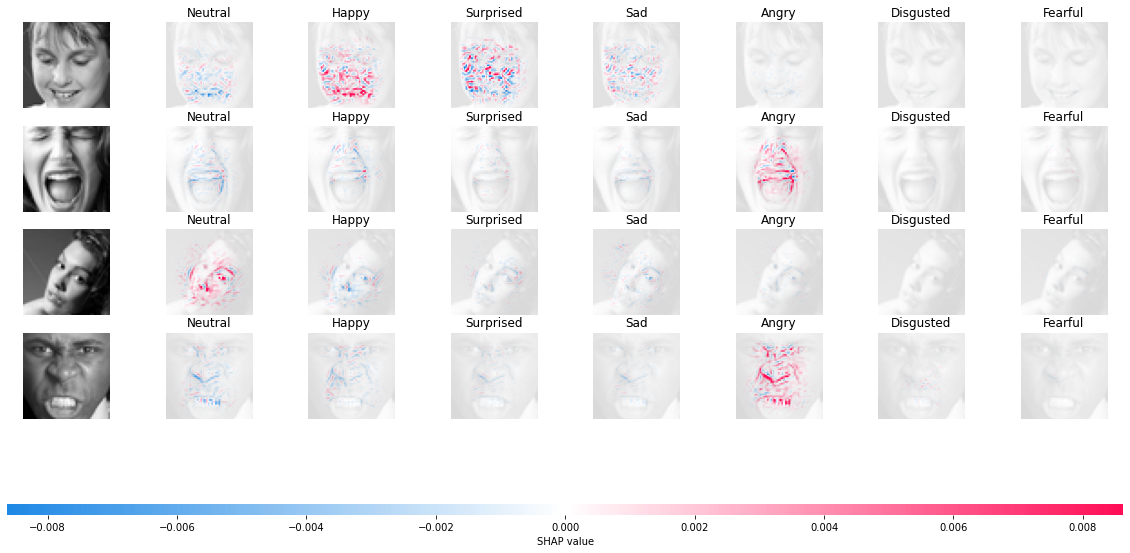

In [7]:
emotion_values = emotion_explainer.shap_values(x_test[:4])

index_names = np.tile(np.array(['Neutral', 'Happy', 'Surprised', 'Sad', 'Angry', 'Disgusted', 'Fearful']), (4, 1))

shap.image_plot(emotion_values, x_test[:4], index_names)

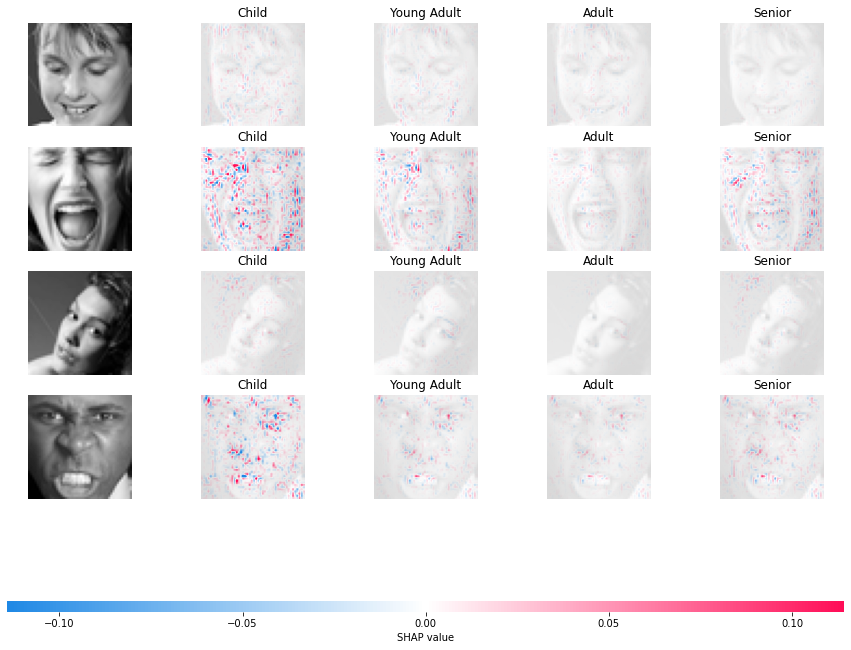

In [8]:
age_values = age_explainer.shap_values(x_test[:4])

index_names = np.tile(np.array(['Child', 'Young Adult', 'Adult', 'Senior']), (4, 1))

shap.image_plot(age_values, x_test[:4], index_names)